In [1]:
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pandas as pd
import geopandas as gpd
import os
import altair as alt
alt.data_transformers.disable_max_rows()
import seaborn as sns
from numpy.linalg import svd
from scipy.linalg import qr

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import missingno as msno

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

from sklearn.manifold import TSNE
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df = pd.read_csv("elwha.cleaned.2000-2023.csv", parse_dates=['DateTime'])
df.head()

,DateTime,Site,Temp
0,2000-07-01 00:00:00+00:00,MS02,NaN
1,2000-07-01 00:00:00+00:00,MS03,NaN
2,2000-07-01 00:00:00+00:00,MS04,NaN
3,2000-07-01 00:00:00+00:00,MS05,NaN
4,2000-07-01 00:00:00+00:00,MS06,NaN


In [3]:
sites = pd.read_excel("Temperature Site Names.xlsx")
sites.head(10)

,SITE_NO,Temp_Alias,FOODWEB_SITE_ID,Monitoring,LAT,LONG,RKM,ELEVATION,DRAIN_AREA,SECTION,HABITAT,AUX_BANK,AUX_RKM,NAME,NOTES,ALT_NAME
0,91,ES01,NaN,X,48.149795,-123.558373,0.00,NaN,NaN,Estuary,NaN,NaN,NaN,NDE1,NaN,NaN
1,92,ES02,NaN,X,48.149355,-123.559532,0.00,NaN,NaN,Estuary,NaN,NaN,NaN,NDE2,NaN,NaN
2,93,ES03,NaN,X,48.145556,-123.567222,0.00,NaN,NaN,Estuary,NaN,NaN,NaN,WESC,NaN,NaN
3,90,MS00,ELMSEJ,X,48.121900,-123.554400,0.00,NaN,NaN,Lower River,MS,NaN,NaN,MS @ ELJ,NaN,NaN
4,81,MS01,ELMSNM,X,48.144146,-123.563730,0.48,1.24,835.24,Lower River,MS,NaN,NaN,Mouth,Daily only,End of Lower Hatchery Road
5,62,FP01,ELSC08,X,48.143108,-123.561690,0.50,1.24,835.24,Lower River,SC,Right,0.1,SC 8,NaN,NaN
6,27,MS02,ELMSNM,NaN,48.142634,-123.563924,0.60,1.24,835.24,Lower River,MS,NaN,NaN,Habitat unit 61,NaN,NaN
7,59,FP02,ELSC07,NaN,48.141446,-123.563843,0.60,0.25,835.24,Lower River,SC,NaN,NaN,SC 7,NaN,"ELSC6, ELSC8"
8,60,FP03,ELSC07,NaN,48.142943,-123.561950,0.80,1.24,835.24,Lower River,SC,Right,0.1,SC 7 Bottom,NaN,NaN
9,63,FP04,ELSC08,NaN,48.142735,-123.561276,0.80,1.24,835.24,Lower River,SC,NaN,NaN,SC 8 Bottom,NaN,NaN


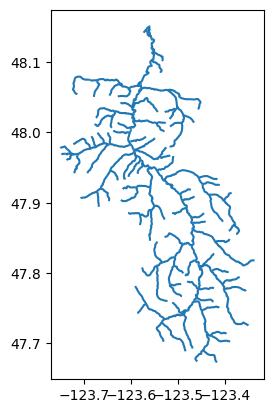

In [4]:
gdf = gpd.read_file("elwha_streams\elwha_streams.shp")
gdf.plot()
plt.show()

In [5]:
gdf.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
0,23997618,2005-09-06,Medium,None,None,2.699,17110020000003,With Digitized,23999528,ArtificialPath,55800,0.034007,True,0,"LINESTRING Z (-123.71950 48.07592 0.00000, -12..."
1,23997144,2001-04-17,Medium,None,None,0.265,17110020000004,With Digitized,23999574,ArtificialPath,55800,0.003445,True,0,"LINESTRING Z (-123.74104 47.97013 0.00000, -12..."
2,23997020,2001-04-17,Medium,None,None,0.943,17110020000009,With Digitized,0,Coastline,56600,0.010803,True,0,"LINESTRING Z (-123.55980 48.15044 0.00000, -12..."
3,23997022,2001-04-17,Medium,1531449,Elwha River,1.655,17110020000010,With Digitized,23999494,ArtificialPath,55800,0.016869,True,0,"LINESTRING Z (-123.55959 48.13766 0.00000, -12..."
4,23997024,2001-04-17,Medium,1531449,Elwha River,0.080,17110020000011,With Digitized,23999494,ArtificialPath,55800,0.000907,True,0,"LINESTRING Z (-123.55885 48.13713 0.00000, -12..."


## All kinds of rivers and creeks (and Site Locations)

In [6]:
gdf['GNIS_NAME'].value_counts()

GNIS_NAME
Elwha River                  76
Boulder Creek                 6
Lillian River                 6
Goldie River                  5
Cat Creek                     4
Long Creek                    4
Indian Creek                  4
Godkin Creek                  4
Hayes River                   4
South Branch Little River     4
Little River                  3
Hughes Creek                  3
South Fork Boulder Creek      3
Griff Creek                   3
North Fork Boulder Creek      3
Freeman Creek                 3
Wolf Creek                    2
Cowen Creek                   2
Madison Creek                 2
Delabarre Creek               2
Lost River                    2
Fairchild Creek               2
Schoeffel Creek               1
Leitha Creek                  1
Stony Creek                   1
McCartney Creek               1
Prescott Creek                1
Windfall Creek                1
Fitzhenry Creek               1
Haggerty Creek                1
Idaho Creek                   

In [13]:
river_base = alt.Chart(gdf).mark_geoshape(fill='lightgrey')\
.properties(height = 800, width = 400).interactive()

# All Sites Point
all_site = alt.Chart(sites).mark_point().encode(
    longitude='LONG:Q', latitude='LAT:Q',
    shape = alt.Shape('Monitoring:N'), color = alt.Color('Monitoring:N')
)
 
# 
base_map = river_base + all_site
base_map

alt.LayerChart(...)

## Clean The Site Names

In [18]:
site_1 = sorted(df["Site"].unique())
len_1 = len(site_1)
print(f"Site in df DataFrame, number is {len_1}:")
print(site_1)
print()

site_2 = sorted(sites["Temp_Alias"].unique())
len_2 = len(site_2)
print(f"Site in sites DataFrame, number is {len_2}:")
print(site_2)
print()

intersection = sorted(list(set(site_1).intersection(site_2)))
len_3 = len(intersection)
print(f"Sites available for both DataFrame, number is {len_3}:")
print(intersection)
print()

difference = list(set(site_1).symmetric_difference(site_2))
len_4 = len(difference)
print(f"Sites different for both DataFrame, number is {len_4}:")
print(difference)

print("There is a conflict site: MS16_5 and MS16-5")
print("Convert all MS16_5 to MS16-5")
df['Site'] = df['Site'].replace('MS16_5', 'MS16-5')

Site in df DataFrame, number is 88:
['BO01', 'ES01', 'ES02', 'ES03', 'FP01', 'FP02', 'FP03', 'FP04', 'FP05', 'FP06', 'FP07', 'FP08', 'FP09', 'FP10', 'FP11', 'FP12', 'FP13', 'FP14', 'FP15', 'FP16', 'FP17', 'FP18', 'FP21', 'FP22', 'FP23', 'FP24', 'FP25', 'FP26', 'FP28', 'GR01', 'HA01', 'HU01', 'IC01', 'IC02', 'IC09', 'IC11', 'IC12', 'IC19', 'ID01', 'LL01', 'LO01', 'LR02', 'LR11', 'LR14', 'LR22', 'LS01', 'MA01', 'MS00', 'MS01', 'MS02', 'MS03', 'MS04', 'MS05', 'MS06', 'MS07', 'MS08', 'MS09', 'MS10', 'MS11', 'MS12', 'MS13', 'MS14', 'MS15', 'MS16', 'MS16-5', 'MS16_5', 'MS17', 'MS18', 'MS19', 'MS20', 'MS21', 'MS22', 'MS23', 'MS24', 'MS25', 'MS26', 'MS27', 'MS28', 'MS29', 'MS30', 'MS31', 'MS32', 'MS33', 'MS34', 'MS35', 'MS36', 'MS38', 'MS39']

Site in sites DataFrame, number is 93:
['BO01', 'ES01', 'ES02', 'ES03', 'FP01', 'FP02', 'FP03', 'FP04', 'FP05', 'FP06', 'FP07', 'FP08', 'FP09', 'FP10', 'FP11', 'FP12', 'FP13', 'FP14', 'FP15', 'FP16', 'FP17', 'FP18', 'FP19', 'FP20', 'FP21', 'FP22', 'FP23'

## Visualize the trend and flow of Temp by each Year and each Site

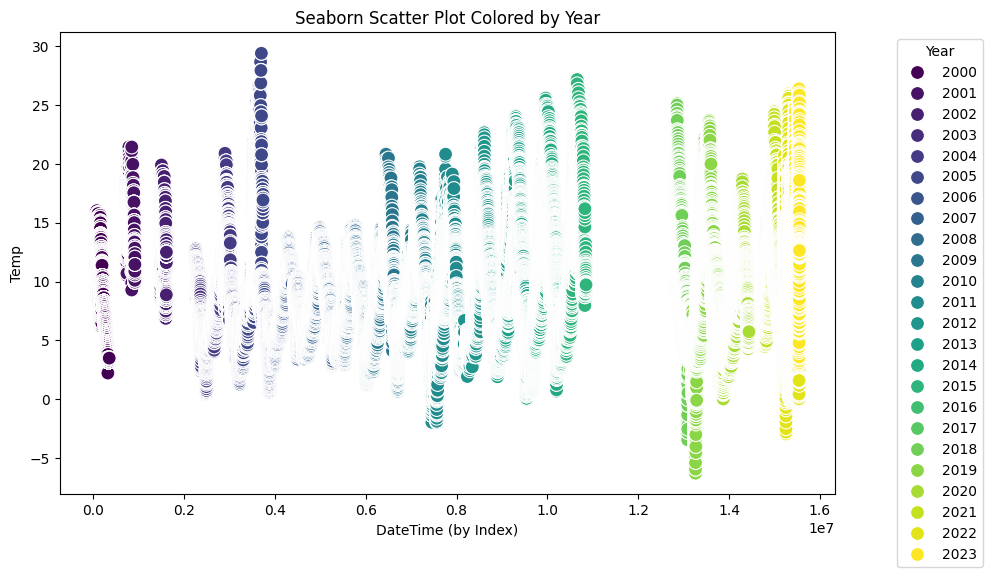

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.index, y='Temp', hue=df['DateTime'].dt.year, palette='viridis', legend='full', s=100)

plt.xlabel('DateTime (by Index)')
plt.ylabel('Temp')
plt.title('Seaborn Scatter Plot Colored by Year')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

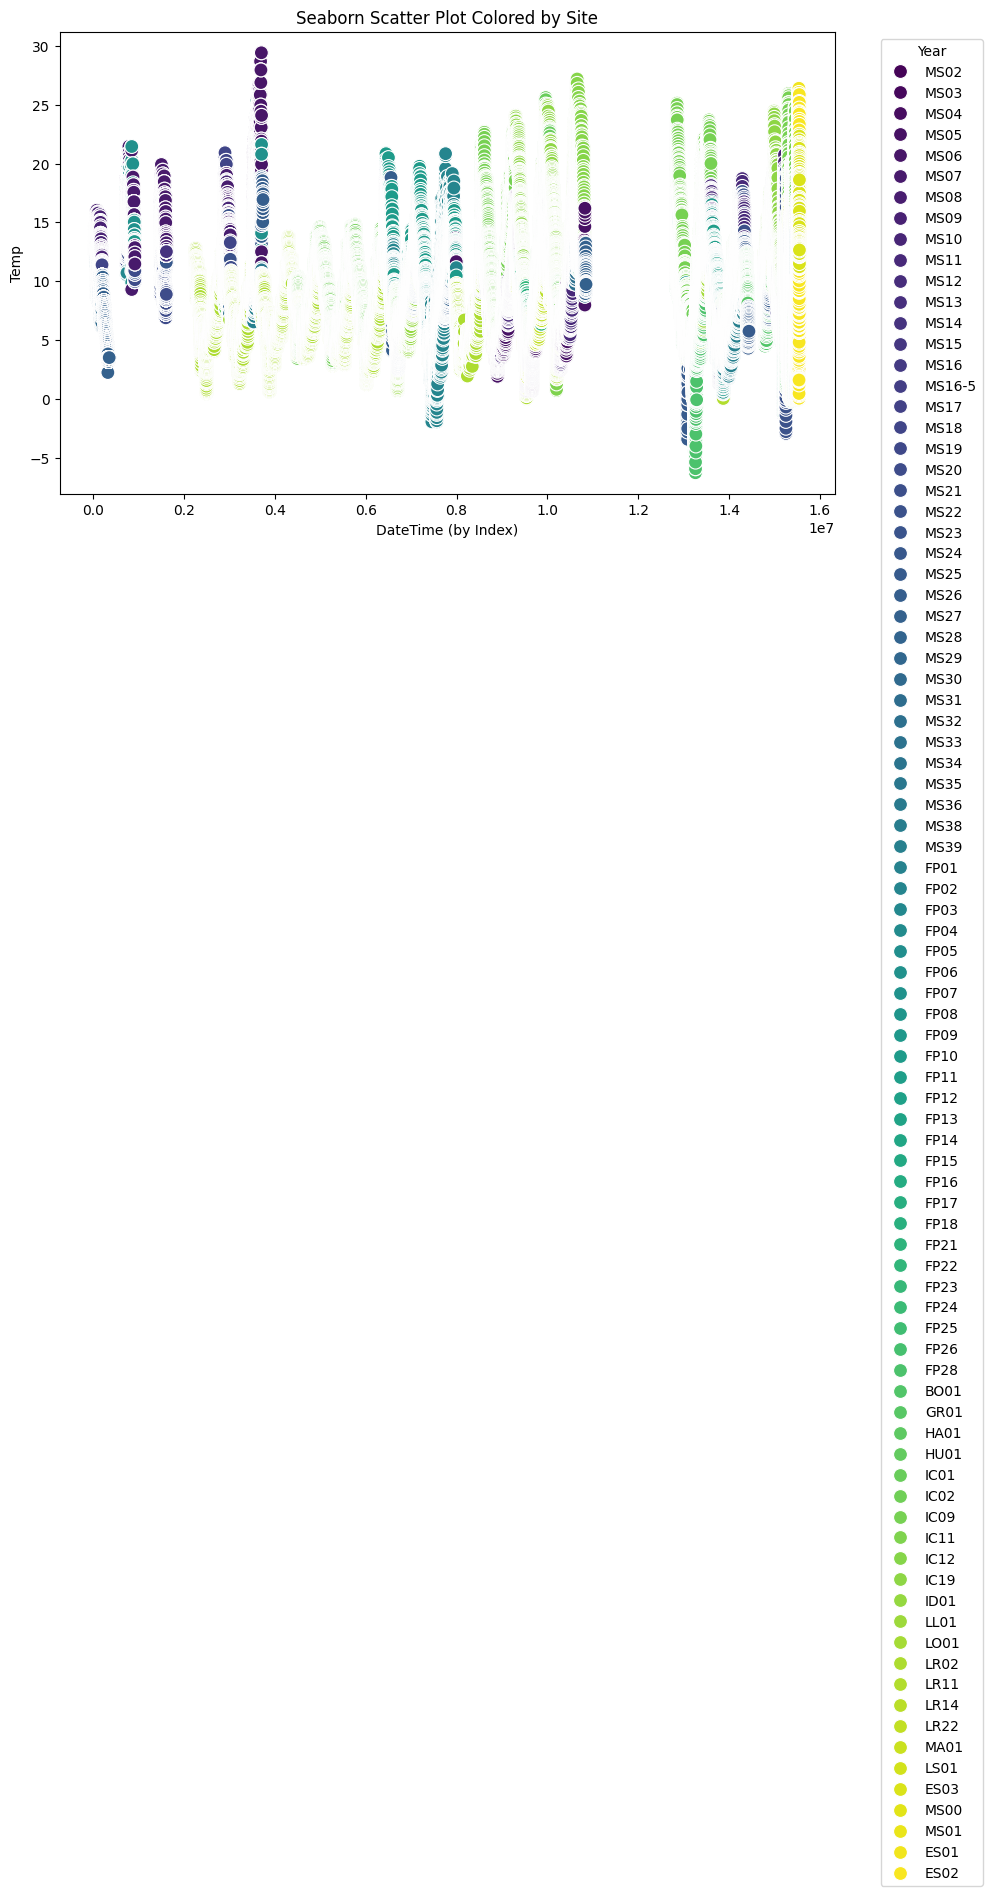

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.index, y='Temp', hue='Site', palette='viridis', legend='full', s=100)

plt.xlabel('DateTime (by Index)')
plt.ylabel('Temp')
plt.title('Seaborn Scatter Plot Colored by Site')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

## Missing Values Analysis

In [30]:
site_dfs = {}
for site, site_group in df.groupby('Site'):
    site_dfs[site] = site_group[['DateTime', 'Temp']].copy()

for site, site_group in df.groupby('Site'):
    print(f"Site {site}:")
    for interval_start, interval_group in site_group.resample('3M', on='DateTime'):
        null_percentage = interval_group['Temp'].isnull().mean() * 100
        if null_percentage < 100:
            interval_start_str = interval_start.strftime('%Y-%m-%d')
            interval_end = interval_start + pd.DateOffset(months=3)
            interval_end_str = interval_end.strftime('%Y-%m-%d')
            print(f"Null percentage for {interval_start_str} to {interval_end_str}: {null_percentage:.2f}%")
    print()

Site BO01:
Null percentage for 2018-10-31 to 2019-01-31: 0.00%
Null percentage for 2019-01-31 to 2019-04-30: 0.00%
Null percentage for 2019-04-30 to 2019-07-30: 0.00%
Null percentage for 2019-07-31 to 2019-10-31: 10.46%
Null percentage for 2021-04-30 to 2021-07-30: 97.24%
Null percentage for 2021-07-31 to 2021-10-31: 0.00%
Null percentage for 2021-10-31 to 2022-01-31: 87.55%
Null percentage for 2022-01-31 to 2022-04-30: 67.67%
Null percentage for 2022-04-30 to 2022-07-30: 25.42%
Null percentage for 2022-07-31 to 2022-10-31: 0.00%
Null percentage for 2022-10-31 to 2023-01-31: 25.68%
Null percentage for 2023-01-31 to 2023-04-30: 73.62%
Null percentage for 2023-04-30 to 2023-07-30: 0.00%
Null percentage for 2023-07-31 to 2023-10-31: 0.00%
Null percentage for 2023-10-31 to 2024-01-31: 0.00%

Site ES01:
Null percentage for 2022-10-31 to 2023-01-31: 0.00%
Null percentage for 2023-01-31 to 2023-04-30: 0.00%
Null percentage for 2023-04-30 to 2023-07-30: 0.00%
Null percentage for 2023-07-31 to 

# Further Steps to be done...

## Sites Similarity (Clustering)

In [41]:
# Initialize an empty list to store the results
results = []

# Iterate over columns and collect information
for col in sites.columns:
    results.append({'Column': col, 'Null Count': sites[col].isna().sum(), 'Data Type': sites[col].dtype})

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

             Column  Null Count Data Type
0           SITE_NO           0     int64
1        Temp_Alias           0    object
2   FOODWEB_SITE_ID          20    object
3        Monitoring          62    object
4               LAT           0   float64
5              LONG           0   float64
6               RKM           0   float64
7         ELEVATION           4   float64
8        DRAIN_AREA           4   float64
9           SECTION           0    object
10          HABITAT           3    object
11         AUX_BANK          67    object
12          AUX_RKM          64   float64
13             NAME           0    object
14            NOTES          88    object
15         ALT_NAME          67    object


### KMeans

C:\Users\chong\AppData\Local\Temp\ipykernel_7504\2774453822.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_sites['Cluster'] = kmeans.fit_predict(scaled_data)


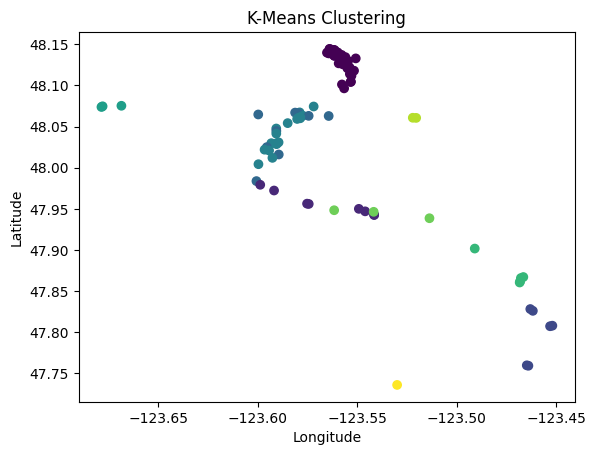

Cluster Centers:
         LAT        LONG        RKM   ELEVATION  DRAIN_AREA
0  48.128794 -123.558368   2.765882    6.288235  830.430294
1  47.955720 -123.564756  26.787500  223.631250  475.508750
2  47.798108 -123.459679  53.333333  540.081667  120.310000
3  48.043620 -123.586134  14.577778  113.686667   41.038889
4  48.042569 -123.586562  14.946667   84.012222  693.261111
5  48.074511 -123.675018  11.000000  153.133333   28.833333
6  47.871411 -123.472266  38.740000  431.734000  257.046000
7  47.944395 -123.538962  29.666667  305.943333   45.776667
8  48.060564 -123.521175  12.000000  184.810000   59.610000
9  47.736000 -123.529900  65.000000  666.500000   21.000000


In [45]:
num_sites = sites.select_dtypes(include=np.number).drop(columns=['SITE_NO', 'AUX_RKM'])
cleaned_sites = num_sites.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_sites)

# Choose the number of clusters (K)
k = 10

# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
cleaned_sites['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters (for 2D data)
plt.scatter(cleaned_sites['LONG'], cleaned_sites['LAT'], c=cleaned_sites['Cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering')
plt.show()

# Display the cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cleaned_sites.columns[:-1])
print("Cluster Centers:")
print(cluster_centers)

In [46]:
brush = alt.selection_interval()

river_base = alt.Chart(gdf).mark_geoshape(fill='lightgrey')\
.properties(height = 800, width = 400).interactive()

# All active Sites Point
all_site = alt.Chart(cleaned_sites).mark_point().encode(
    longitude='LONG:Q', latitude='LAT:Q',
    shape = alt.condition(brush, 'Cluster:N', alt.value('grey')), color=alt.condition(brush, 'Cluster:N', alt.value('grey')),
).add_params(brush)

base_map = river_base + all_site
base_map

alt.LayerChart(...)

## Clustering considering Temp Data

## Merging

In [51]:
# Clean null values in df
df_cleaned = df.dropna()

# Merging
merged = df_cleaned.merge(sites, left_on='Site', right_on='Temp_Alias', how='left')

# Only consider meaningful numerical columns
merged_cleaned = merged.select_dtypes(include=np.number).drop(columns=['SITE_NO', 'AUX_RKM'])
merged_cleaned.dropna(inplace=True)
merged_cleaned.head()

,Temp,LAT,LONG,RKM,ELEVATION,DRAIN_AREA
0,12.32,48.144293,-123.563890,1.00,1.24,835.24
1,12.43,48.135921,-123.561450,1.76,0.25,835.24
2,12.52,48.129888,-123.558492,2.50,-0.24,830.36
3,12.78,48.113820,-123.553660,5.00,17.89,823.82
4,12.78,48.096357,-123.556540,8.00,26.59,818.57


### KMeans

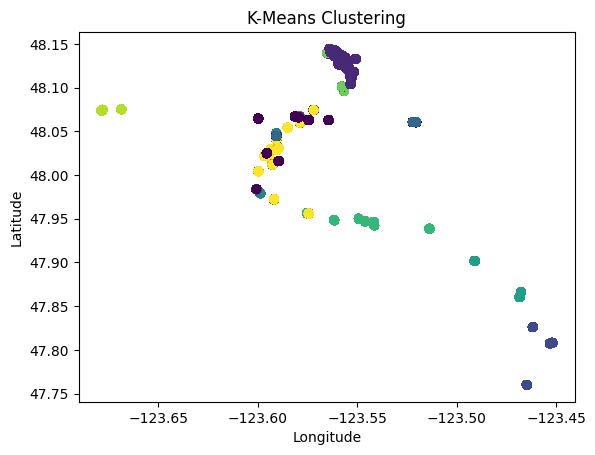

Cluster Centers:
        Temp        LAT        LONG        RKM   ELEVATION  DRAIN_AREA
0  12.048961  48.053294 -123.581772  13.120829  113.781084   46.132179
1  14.088610  48.127593 -123.559020   2.890416    6.869224  829.639578
2   6.356843  47.778112 -123.462980  55.885300  563.344432  132.301278
3   6.185083  48.050937 -123.577696  13.573969  134.121847   47.935054
4   6.070834  48.021885 -123.591158  17.938497  110.027260  653.908752
5   7.078937  47.865451 -123.469910  40.220819  439.321261  248.547645
6   7.930854  47.945563 -123.545527  29.069868  279.668397  128.934121
7   6.488529  48.128487 -123.558563   2.742904    5.956075  830.172229
8  12.477026  48.074838 -123.671704  11.000000  144.236447   34.893481
9  12.631088  48.025532 -123.589577  17.409814  104.821269  662.631348


In [54]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_cleaned)

# Choose the number of clusters (K)
k = 10

# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
merged_cleaned['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the clusters (for 2D data)
plt.scatter(merged_cleaned['LONG'], merged_cleaned['LAT'], c=merged_cleaned['Cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering')
plt.show()

# Display the cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=merged_cleaned.columns[:-1])
print("Cluster Centers:")
print(cluster_centers)

In [64]:
merged_cluster = merged_cleaned[['LAT','LONG','Cluster']].drop_duplicates()

brush = alt.selection_interval()

river_base = alt.Chart(gdf).mark_geoshape(fill='lightgrey')\
.properties(height = 800, width = 400).interactive()

# All active Sites Point
all_site = alt.Chart(merged_cluster).mark_point().encode(
    longitude='LONG:Q', latitude='LAT:Q',
    color=alt.condition(brush, 'Cluster:N', alt.value('grey')),
).add_params(brush)

bars = alt.Chart(merged_cluster).mark_bar().encode(
    y='count(Cluster):Q',
    color='Cluster:N',
    x='Cluster:N'
).transform_filter(
    brush
).properties(height = 200, width = 400)

base_map = bars & (river_base + all_site)
base_map

alt.VConcatChart(...)

## Random Forest

In [69]:
rfc_merged = merged.copy()
rfc_merged.head()

,DateTime,Site,Temp,SITE_NO,Temp_Alias,FOODWEB_SITE_ID,Monitoring,LAT,LONG,RKM,ELEVATION,DRAIN_AREA,SECTION,HABITAT,AUX_BANK,AUX_RKM,NAME,NOTES,ALT_NAME
0,2000-07-21 01:00:00+00:00,MS03,12.32,16,MS03,ELMSNM,NaN,48.144293,-123.563890,1.00,1.24,835.24,Lower River,MS,NaN,NaN,Channel below Jetty,NaN,NaN
1,2000-07-21 01:00:00+00:00,MS08,12.43,44,MS08,NaN,NaN,48.135921,-123.561450,1.76,0.25,835.24,Lower River,MS,NaN,NaN,Lower Hunts Rd,NaN,NaN
2,2000-07-21 01:00:00+00:00,MS09,12.52,68,MS09,ELMSHR,X,48.129888,-123.558492,2.50,-0.24,830.36,Lower River,MS,NaN,NaN,Upper Hunts Road,NaN,Upper Hunt's Road
3,2000-07-21 01:00:00+00:00,MS15,12.78,8,MS15,EMMSFW,NaN,48.113820,-123.553660,5.00,17.89,823.82,Lower River,MS,NaN,NaN,Below Elwha River Road Bridge,NaN,NaN
4,2000-07-21 01:00:00+00:00,MS18,12.78,7,MS18,NaN,NaN,48.096357,-123.556540,8.00,26.59,818.57,Lower River,MS,NaN,NaN,Below Elwha Dam,NaN,NaN


In [76]:
# Ordinal
label_encoder = LabelEncoder()

rfc_merged.loc[:, 'SECTION_ENCODED'] = label_encoder.fit_transform(rfc_merged['SECTION'])

# Nominal
rfc_merged['HABITAT'] = rfc_merged['HABITAT'].astype('category') 

# Assigning numerical values and storing it in another columns 
rfc_merged['HABITAT'] = rfc_merged['HABITAT'].cat.codes 

enc = OneHotEncoder() 
enc_data = pd.DataFrame(enc.fit_transform(rfc_merged[['HABITAT']]).toarray()) 
enc_data.columns = enc.get_feature_names_out(['HABITAT'])

# Merge with main 
New_df = rfc_merged.join(enc_data)

df_rfc = New_df.copy()
df_rfc = New_df.drop(['LONG', 'LAT', 'DateTime', 'SECTION', 'HABITAT', 'SITE_NO',
                'Temp_Alias', 'FOODWEB_SITE_ID', 'Monitoring', 'AUX_BANK', 'AUX_RKM', 'NAME',
                'NOTES', 'ALT_NAME'], axis=1)

# Drop null values for now !!!
df_rfc_cleaned = df_rfc.dropna()

X = df_rfc_cleaned.drop(['Site'], axis=1)
y = df_rfc_cleaned['Site']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
              precision    recall  f1-score   support

        BO01       1.00      1.00      1.00      4666
        FP01       1.00      1.00      1.00      1977
        FP02       1.00      1.00      1.00      4512
        FP03       0.91      1.00      0.95        39
        FP04       1.00      1.00      1.00      2559
        FP05       1.00      0.93      0.96       296
        FP06       0.98      1.00      0.99       924
        FP07       1.00      1.00      1.00       454
        FP08       1.00      1.00      1.00       479
        FP09       1.00      1.00      1.00      4014
        FP10       1.00      1.00      1.00      5652
        FP11       1.00      1.00      1.00      3982
        FP12       1.00      1.00      1.00       422
        FP13       0.83      0.50      0.63       265
        FP14       0.95      0.99      0.97      2531
        FP15       1.00      1.00      1.00       295
        FP16       1.00      1.00      1.00      2460
    

### Feature Importance

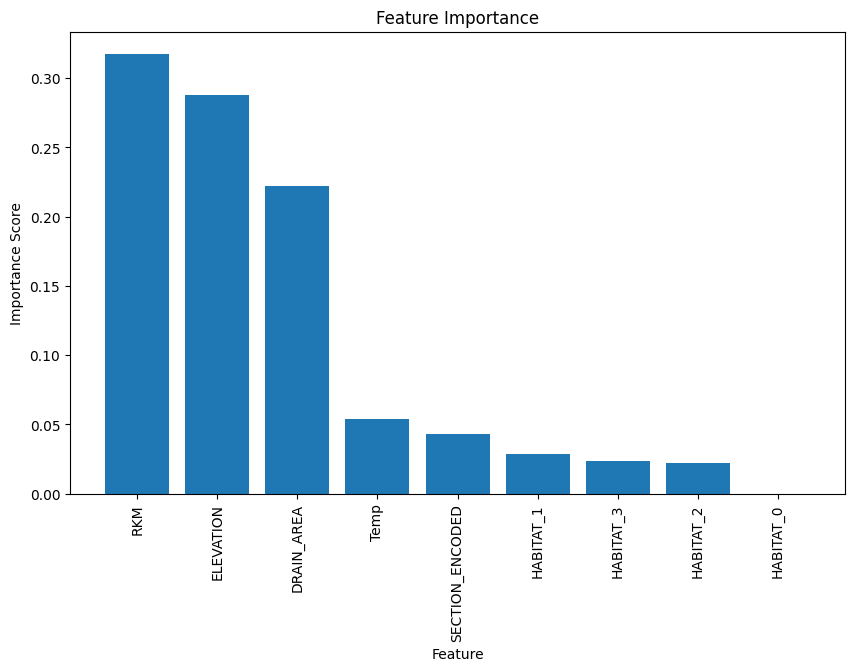

In [77]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

column_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), column_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

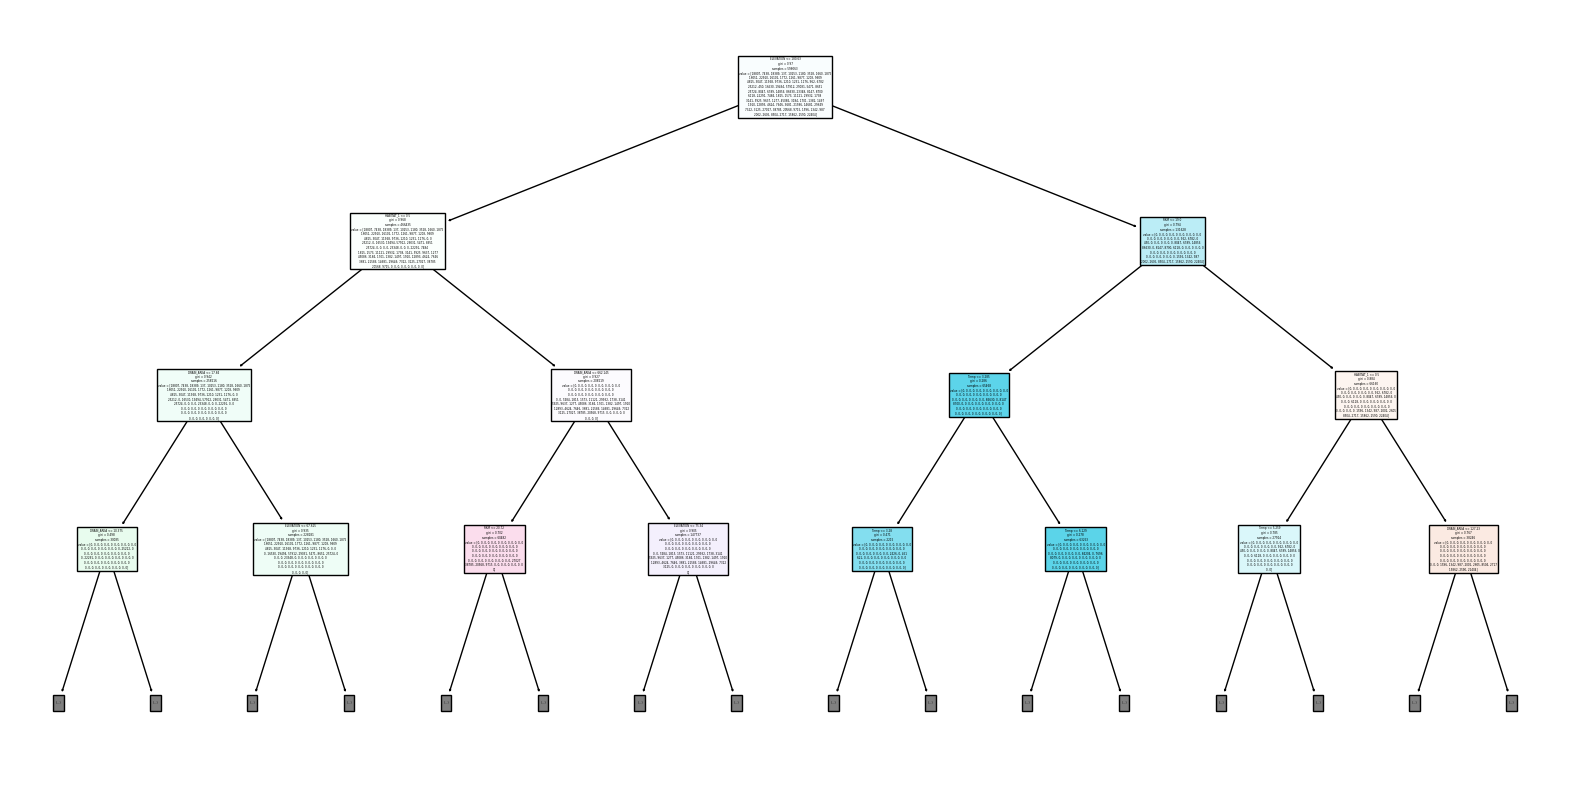

In [78]:
# Visualize the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], filled=True, feature_names=X_train.columns, max_depth = 3)
plt.show()